In [1]:
import numpy as np
from filterpy.kalman import ExtendedKalmanFilter, UnscentedKalmanFilter, MerweScaledSigmaPoints

# 状态转移矩阵
dt = 0.1# 时间步长
F = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

# 观测矩阵
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

# 过程噪声协方差矩阵
Q = np.eye(4) * 0.1

# 观测噪声协方差矩阵
R = np.eye(2) * 1.0

# 初始状态和协方差
x0 = np.array([0, 0, 1, 1])  # 初始位置和速度
P0 = np.eye(4) * 1.0

# 扩展卡尔曼滤波 (EKF)
def hx(x):
    """观测函数"""
    return np.dot(H, x)

def fx(x, dt):
    """状态转移函数"""
    return np.dot(F, x)

ekf = ExtendedKalmanFilter(dim_x=4, dim_z=2)
ekf.x = x0
ekf.P = P0
ekf.F = F
ekf.H = H
ekf.R = R
ekf.Q = Q

# 无迹卡尔曼滤波 (UKF)
points = MerweScaledSigmaPoints(n=4, alpha=0.1, beta=2.0, kappa=-1)
ukf = UnscentedKalmanFilter(dim_x=4, dim_z=2, dt=dt, fx=fx, hx=hx, points=points)
ukf.x = x0
ukf.P = P0
ukf.R = R
ukf.Q = Q

# 模拟数据
true_states = []
measurements = []
for _ in range(50):
    true_states.append(x0)
    x0 = np.dot(F, x0) + np.random.multivariate_normal(np.zeros(4), Q)
    measurements.append(np.dot(H, x0) + np.random.multivariate_normal(np.zeros(2), R))

# 滤波过程
ekf_states = []
ukf_states = []
for z in measurements:
    ekf.predict()
    ekf.update(z, HJacobian=lambda x: H, Hx=hx)
    ekf_states.append(ekf.x.copy())
    
    ukf.predict()
    ukf.update(z)
    ukf_states.append(ukf.x.copy())

# 输出结果
print("EKF 估计结果:", ekf_states[-1])
print("UKF 估计结果:", ukf_states[-1])


EKF 估计结果: [ 8.02939307 12.82843254  1.54909912  3.39123511]
UKF 估计结果: [ 8.02940393 12.82844406  1.54913667  3.39127491]


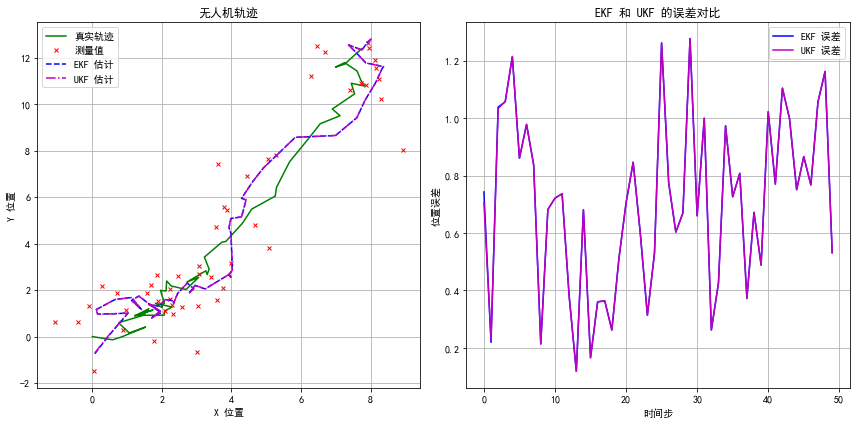

In [2]:
import matplotlib.pyplot as plt

# 提取真实状态、测量值和估计值
true_x = [s[0] for s in true_states]
true_y = [s[1] for s in true_states]
meas_x = [z[0] for z in measurements]
meas_y = [z[1] for z in measurements]
ekf_x = [s[0] for s in ekf_states]
ekf_y = [s[1] for s in ekf_states]
ukf_x = [s[0] for s in ukf_states]
ukf_y = [s[1] for s in ukf_states]

# 计算 EKF 和 UKF 的误差
ekf_error = [np.sqrt((tx - ex)**2 + (ty - ey)**2) for tx, ty, ex, ey in zip(true_x, true_y, ekf_x, ekf_y)]
ukf_error = [np.sqrt((tx - ux)**2 + (ty - uy)**2) for tx, ty, ux, uy in zip(true_x, true_y, ukf_x, ukf_y)]

# 绘制轨迹
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(true_x, true_y, 'g-', label='真实轨迹')
plt.plot(meas_x, meas_y, 'rx', label='测量值', markersize=4)
plt.plot(ekf_x, ekf_y, 'b--', label='EKF 估计')
plt.plot(ukf_x, ukf_y, 'm-.', label='UKF 估计')
plt.xlabel('X 位置')
plt.ylabel('Y 位置')
plt.title('无人机轨迹')
plt.legend()
plt.grid(True)

# 绘制误差
plt.subplot(1, 2, 2)
plt.plot(ekf_error, 'b-', label='EKF 误差')
plt.plot(ukf_error, 'm-', label='UKF 误差')
plt.xlabel('时间步')
plt.ylabel('位置误差')
plt.title('EKF 和 UKF 的误差对比')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
